In [9]:
%cd /content/drive/MyDrive/MLCB/Project/Data

/content/drive/MyDrive/MLCB/Project/Data


In [2]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import json
import networkx as nx
import numpy as np
import pickle
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.nn as nn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install --upgrade torch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
events_extract = pd.read_csv("events_extract.csv")

In [11]:
events_extract = events_extract.drop(columns=["Unnamed: 0","interaction","action"],index=None)

In [12]:
events_extract

,Unnamed: 0.1,index,id1,name1,id2,name2,mechanism,label
0,0,0,DB12001,Abemaciclib,DB01118,Amiodarone,The risk or severity of adverse effects,0
1,1,1,DB12001,Abemaciclib,DB11901,Apalutamide,The serum concentration,1
2,2,2,DB12001,Abemaciclib,DB00673,Aprepitant,The serum concentration,1
3,3,3,DB12001,Abemaciclib,DB00289,Atomoxetine,The metabolism,2
4,4,4,DB12001,Abemaciclib,DB00188,Bortezomib,The metabolism,2
...,...,...,...,...,...,...,...,...
37259,37259,37259,DB01149,Nefazodone,DB09048,Netupitant,The serum concentration,1
37260,37260,37260,DB01149,Nefazodone,DB00622,Nicardipine,The metabolism,2
37261,37261,37261,DB11828,Neratinib,DB09048,Netupitant,The serum concentration,1
37262,37262,37262,DB09048,Netupitant,DB00622,Nicardipine,The serum concentration,1


In [13]:
def load_graph2seq_features(filepath):
    """Load graph2seq features dictionary from a file."""
    with open(filepath, 'rb') as f:
        features = pickle.load(f)
    return features
graph2seq_features = load_graph2seq_features("graph2seq_features.pkl")

In [14]:
from torch.utils.data import Dataset
import torch

class DDIDataset(Dataset):
    def __init__(self, ddi_df, graph2seq_features):
        self.ddi_df = ddi_df
        self.graph2seq_features = graph2seq_features

    def __len__(self):
        return len(self.ddi_df)

    def __getitem__(self, idx):
        row = self.ddi_df.iloc[idx]
        id1 = row['id1']
        id2 = row['id2']
        label = row['label']

        # No unsqueeze! Flat input for MLP
        x1 = torch.tensor(self.graph2seq_features[id1], dtype=torch.float32)
        x2 = torch.tensor(self.graph2seq_features[id2], dtype=torch.float32)

        # Convert label to tensor (Long type for CrossEntropyLoss)
        label = torch.tensor(label, dtype=torch.long)

        return x1, x2, label


In [15]:


class BiRNN_DDI_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiRNN_DDI_Model, self).__init__()

        self.bigru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        self.mlp = nn.Sequential(
            nn.Linear(4*hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def encode(self, x):
        output, _ = self.bigru(x)
        pooled_output = torch.mean(output, dim=1)
        return pooled_output

    def forward(self, seq1, seq2):
        emb1 = self.encode(seq1)
        emb2 = self.encode(seq2)
        concat_emb = torch.cat((emb1, emb2), dim=-1)
        out = self.mlp(concat_emb)
        return out


In [16]:
import torch
import torch.nn as nn

class MLP_DDI_Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP_DDI_Model, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(2 * input_size, 512),  # input is drug1 + drug2 concatenated
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x1, x2):
        # x1, x2: shape (batch_size, input_size)
        concat_emb = torch.cat((x1, x2), dim=-1)  # Concatenate features
        out = self.mlp(concat_emb)
        return out


In [17]:

def get_kfold_splits_with_test(dataset, k=7):
    """
    Split dataset into k folds for Train/Validation and reserve one fold for Test.
    """
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    labels = [dataset[i][2] for i in range(len(dataset))]

    splits = list(skf.split(np.zeros(len(labels)), labels))

    # Use the last fold as Test set
    train_val_splits = splits[:-1]
    test_split = splits[-1]

    return train_val_splits, test_split


In [18]:
import matplotlib.pyplot as plt
import torch

def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, device, epochs=80, patience=10, fold=0):
    model = model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # ----------------- Training -----------------
        model.train()
        running_train_loss = 0
        correct_train = 0
        total_train = 0

        for seq1, seq2, labels in train_loader:
            seq1, seq2, labels = seq1.to(device), seq2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(seq1, seq2)

            # Ensure labels are of the correct shape (1D tensor of class indices)
            # Remove the unsqueeze operation or modify output dim of the model to match label tensor's dimensions if necessary.
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)

        # ----------------- Validation -----------------
        model.eval()
        running_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for seq1, seq2, labels in val_loader:
                seq1, seq2, labels = seq1.to(device), seq2.to(device), labels.to(device)
                outputs = model(seq1, seq2)

                # Ensure labels are of the correct shape
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)

        # ----------------- Print -----------------
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # ----------------- Save Best Model -----------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()

            # Save best model checkpoint
            torch.save(best_model_state, f"best_model_fold{fold}.pth")
        else:
            patience_counter += 1

        # ----------------- Early Stopping -----------------
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

    # ----------------- Final Test Evaluation -----------------
    model.load_state_dict(torch.load(f"best_model_fold{fold}.pth"))
    model.eval()

    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for seq1, seq2, labels in test_loader:
            seq1, seq2, labels = seq1.to(device), seq2.to(device), labels.to(device)
            outputs = model(seq1, seq2)

            # Ensure labels are of the correct shape
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_loss = test_loss / len(test_loader)
    test_acc = correct_test / total_test

    print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.4f}")

    # ----------------- Plot Train/Val Loss -----------------
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs Validation Loss (Fold {fold})')
    plt.legend()
    plt.grid()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



Training Fold 1
Epoch 1/30 | Train Loss: 1.4322 | Train Acc: 0.5706 | Val Loss: 1.1213 | Val Acc: 0.6538
Epoch 2/30 | Train Loss: 0.9672 | Train Acc: 0.6899 | Val Loss: 0.9548 | Val Acc: 0.6909
Epoch 3/30 | Train Loss: 0.7931 | Train Acc: 0.7350 | Val Loss: 0.8000 | Val Acc: 0.7278
Epoch 4/30 | Train Loss: 0.6927 | Train Acc: 0.7586 | Val Loss: 0.7617 | Val Acc: 0.7398
Epoch 5/30 | Train Loss: 0.6135 | Train Acc: 0.7841 | Val Loss: 0.7011 | Val Acc: 0.7584
Epoch 6/30 | Train Loss: 0.5472 | Train Acc: 0.8012 | Val Loss: 0.6953 | Val Acc: 0.7605
Epoch 7/30 | Train Loss: 0.4933 | Train Acc: 0.8196 | Val Loss: 0.6523 | Val Acc: 0.7783
Epoch 8/30 | Train Loss: 0.4450 | Train Acc: 0.8369 | Val Loss: 0.7427 | Val Acc: 0.7524
Epoch 9/30 | Train Loss: 0.4073 | Train Acc: 0.8505 | Val Loss: 0.6302 | Val Acc: 0.7951
Epoch 10/30 | Train Loss: 0.3635 | Train Acc: 0.8665 | Val Loss: 0.6126 | Val Acc: 0.8075
Epoch 11/30 | Train Loss: 0.3325 | Train Acc: 0.8770 | Val Loss: 0.6083 | Val Acc: 0.8037
Ep

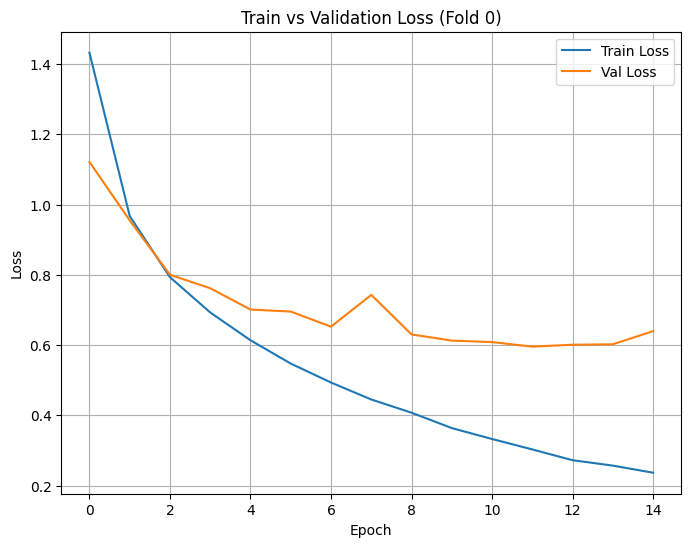


Training Fold 2
Epoch 1/30 | Train Loss: 1.4395 | Train Acc: 0.5680 | Val Loss: 1.0930 | Val Acc: 0.6518
Epoch 2/30 | Train Loss: 0.9676 | Train Acc: 0.6900 | Val Loss: 0.8693 | Val Acc: 0.7174
Epoch 3/30 | Train Loss: 0.7893 | Train Acc: 0.7341 | Val Loss: 0.8164 | Val Acc: 0.7224
Epoch 4/30 | Train Loss: 0.6811 | Train Acc: 0.7622 | Val Loss: 0.7495 | Val Acc: 0.7390
Epoch 5/30 | Train Loss: 0.6038 | Train Acc: 0.7857 | Val Loss: 0.7211 | Val Acc: 0.7471
Epoch 6/30 | Train Loss: 0.5356 | Train Acc: 0.8081 | Val Loss: 0.6405 | Val Acc: 0.7800
Epoch 7/30 | Train Loss: 0.4820 | Train Acc: 0.8239 | Val Loss: 0.6703 | Val Acc: 0.7716
Epoch 8/30 | Train Loss: 0.4322 | Train Acc: 0.8407 | Val Loss: 0.6519 | Val Acc: 0.7887
Epoch 9/30 | Train Loss: 0.3927 | Train Acc: 0.8550 | Val Loss: 0.6221 | Val Acc: 0.7845
Epoch 10/30 | Train Loss: 0.3487 | Train Acc: 0.8717 | Val Loss: 0.6386 | Val Acc: 0.8009
Epoch 11/30 | Train Loss: 0.3214 | Train Acc: 0.8811 | Val Loss: 0.6511 | Val Acc: 0.8068
Ep

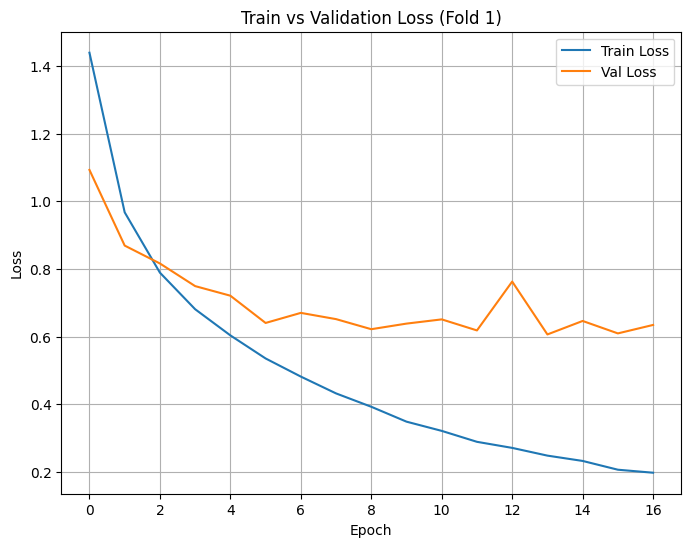


Training Fold 3
Epoch 1/30 | Train Loss: 1.4449 | Train Acc: 0.5612 | Val Loss: 1.1315 | Val Acc: 0.6475
Epoch 2/30 | Train Loss: 0.9771 | Train Acc: 0.6854 | Val Loss: 0.9174 | Val Acc: 0.7091
Epoch 3/30 | Train Loss: 0.8009 | Train Acc: 0.7293 | Val Loss: 0.8619 | Val Acc: 0.7090
Epoch 4/30 | Train Loss: 0.6917 | Train Acc: 0.7612 | Val Loss: 0.7569 | Val Acc: 0.7441
Epoch 5/30 | Train Loss: 0.6101 | Train Acc: 0.7817 | Val Loss: 0.7158 | Val Acc: 0.7506
Epoch 6/30 | Train Loss: 0.5409 | Train Acc: 0.8038 | Val Loss: 0.6881 | Val Acc: 0.7687
Epoch 7/30 | Train Loss: 0.4817 | Train Acc: 0.8230 | Val Loss: 0.6998 | Val Acc: 0.7581
Epoch 8/30 | Train Loss: 0.4325 | Train Acc: 0.8418 | Val Loss: 0.6304 | Val Acc: 0.7918
Epoch 9/30 | Train Loss: 0.3947 | Train Acc: 0.8539 | Val Loss: 0.6399 | Val Acc: 0.7914
Epoch 10/30 | Train Loss: 0.3489 | Train Acc: 0.8712 | Val Loss: 0.6246 | Val Acc: 0.8037
Epoch 11/30 | Train Loss: 0.3258 | Train Acc: 0.8817 | Val Loss: 0.6164 | Val Acc: 0.7983
Ep

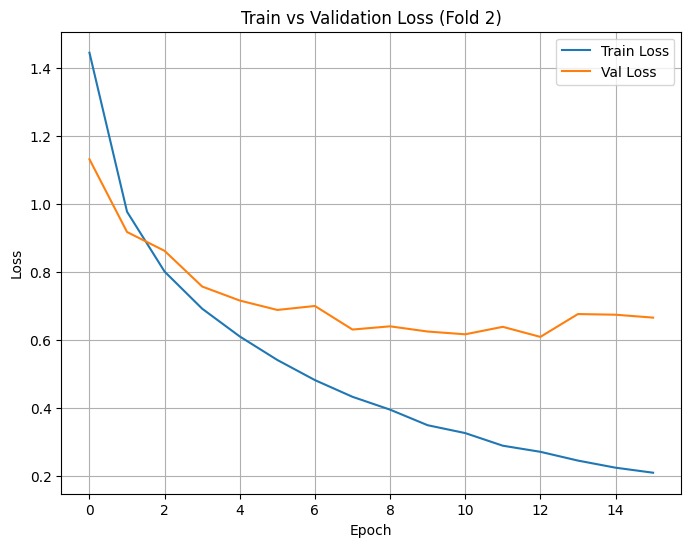


Training Fold 4
Epoch 1/30 | Train Loss: 1.4391 | Train Acc: 0.5623 | Val Loss: 1.0888 | Val Acc: 0.6592
Epoch 2/30 | Train Loss: 0.9737 | Train Acc: 0.6876 | Val Loss: 0.8834 | Val Acc: 0.7142
Epoch 3/30 | Train Loss: 0.8026 | Train Acc: 0.7267 | Val Loss: 0.8382 | Val Acc: 0.7099
Epoch 4/30 | Train Loss: 0.6989 | Train Acc: 0.7552 | Val Loss: 0.8151 | Val Acc: 0.7304
Epoch 5/30 | Train Loss: 0.6163 | Train Acc: 0.7770 | Val Loss: 0.6941 | Val Acc: 0.7657
Epoch 6/30 | Train Loss: 0.5468 | Train Acc: 0.8049 | Val Loss: 0.7057 | Val Acc: 0.7558
Epoch 7/30 | Train Loss: 0.4887 | Train Acc: 0.8229 | Val Loss: 0.6653 | Val Acc: 0.7810
Epoch 8/30 | Train Loss: 0.4380 | Train Acc: 0.8392 | Val Loss: 0.6845 | Val Acc: 0.7734
Epoch 9/30 | Train Loss: 0.3951 | Train Acc: 0.8547 | Val Loss: 0.6207 | Val Acc: 0.7935
Epoch 10/30 | Train Loss: 0.3592 | Train Acc: 0.8678 | Val Loss: 0.6164 | Val Acc: 0.8068
Epoch 11/30 | Train Loss: 0.3300 | Train Acc: 0.8783 | Val Loss: 0.6155 | Val Acc: 0.8103
Ep

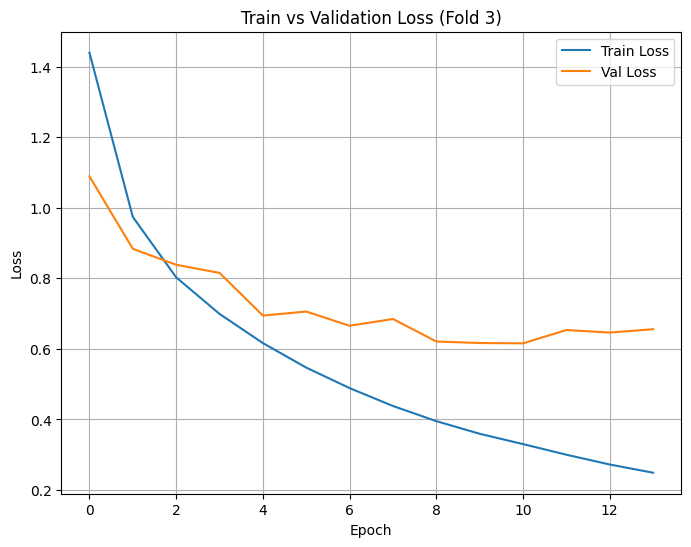

In [22]:
# Create the dataset
ddi_dataset = DDIDataset(events_extract, graph2seq_features)

# Get Train/Val splits and Test split
train_val_splits, test_split = get_kfold_splits_with_test(ddi_dataset, k=5)

# Build Test Loader once
test_loader = DataLoader(Subset(ddi_dataset, test_split[1]), batch_size=32, shuffle=False)

for fold, (train_idx, val_idx) in enumerate(train_val_splits):
    print(f"\nTraining Fold {fold+1}")

    # Create Train and Validation Loaders
    train_loader = DataLoader(Subset(ddi_dataset, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(ddi_dataset, val_idx), batch_size=32, shuffle=False)

    # Initialize a fresh model for each fold
    # model = BiRNN_DDI_Model(
    #     input_size=1,  # Because each graph2seq position is 1D
    #     hidden_size=256,
    #     num_classes=len(events_extract['label'].unique())
    # )
    actual_input_size = next(iter(train_loader))[0].shape[-1]
    model = MLP_DDI_Model(
        input_size=actual_input_size,  # Because each graph2seq position is 1D
        num_classes=len(events_extract['label'].unique())
    )
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # Train model with train_loader, val_loader, test_loader
    train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, device, epochs=30, patience=3, fold=fold)


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, test_loader, device, num_classes):
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for x1, x2, labels in test_loader:
            x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)
            outputs = model(x1, x2)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # store probability distributions for AUC

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # For multi-class AUC, use "ovr" (one-vs-rest)
    try:
        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except ValueError:
        auc = None  # Sometimes AUC fails if classes missing

    print("\n--- Test Set Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"ROC AUC: {auc:.4f}")
    else:
        print(f"ROC AUC: Not Available (single class issue)")

    return accuracy, precision, recall, f1, auc


In [25]:
num_classes = len(events_extract['label'].unique())

In [27]:
# Load best model
model.load_state_dict(torch.load(f"best_model_fold{fold}.pth"))

# Evaluate properly
evaluate_model(model, test_loader, device, num_classes=num_classes)



--- Test Set Metrics ---
Accuracy: 0.9016
Precision: 0.9042
Recall: 0.9016
F1 Score: 0.9013
ROC AUC: Not Available (single class issue)


(0.9016371443907676,
 0.904192194554812,
 0.9016371443907676,
 0.901260659339373,
 None)